<a href="https://colab.research.google.com/github/rhribeiro25/Transfer_Learning-Deep_Learning/blob/main/Practical_Exam_DIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 32 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.1875 - loss: 1.9893 - val_accuracy: 0.4688 - val_loss: 4.9092
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4688 - loss: 4.9856 - val_accuracy: 0.5625 - val_loss: 0.8693
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step - accuracy: 0.4375 - loss: 1.8889 - val_accuracy: 0.6250 - val_loss: 1.4624
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step - accuracy: 0.4688 - loss: 3.2581 - val_accuracy: 0.8750 - val_loss: 0.2910
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step - accura

Validação - Loss: 1.537693738937378, Accuracy: 0.75


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


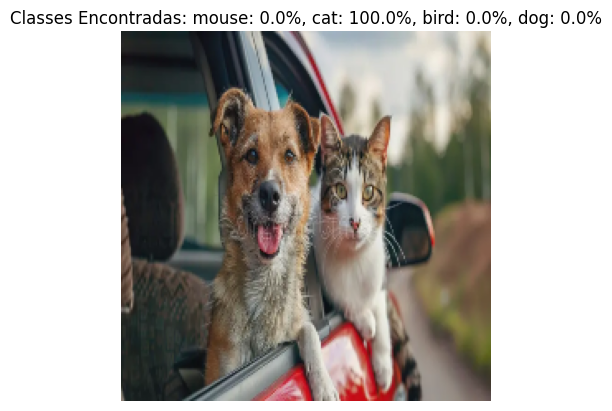

In [95]:
# Importa as bibliotecas necessárias
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

# Carregar o modelo base (VGG16) sem as camadas de classificação
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar as camadas do modelo base para evitar que seus pesos sejam atualizados
for layer in base_model.layers:
    layer.trainable = False

# Construir novas camadas no topo do modelo
x = Flatten()(base_model.output)  # Achata as características extraídas
x = Dense(256, activation='relu')(x)  # Camada densa
x = Dropout(0.5)(x)  # Regularização para evitar overfitting
output_layer = Dense(4, activation='softmax')(x)  # Saída com 4 classes

# Criar o modelo final
model = Model(inputs=base_model.input, outputs=output_layer)

# Compilar o modelo com função de perda e otimizador
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Configuração dos geradores de dados para treinamento e validação
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

# Diretórios contendo os dados de treinamento e validação
train_dir = '/home/train_dir'
val_dir = '/home/val_dir'

# Filtrar pastas indesejadas como '.ipynb_checkpoints'
valid_classes = [folder for folder in os.listdir(train_dir) if folder != '.ipynb_checkpoints']

# Criar geradores de dados
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=valid_classes  # Ignorar pastas não desejadas
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=valid_classes  # Ignorar pastas não desejadas
)

# Treinamento do modelo
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10
)

# Avaliar o modelo nos dados de validação
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validação - Loss: {val_loss}, Accuracy: {val_accuracy}")

# Salvar o modelo treinado
model.save('transfer_learning_model.h5')

# Carregar o modelo salvo
loaded_model = tf.keras.models.load_model('transfer_learning_model.h5')

# Caminho da imagem
img_path = '/home/input/cat_and_dog.png'  # Substitua com o caminho da sua imagem
img = image.load_img(img_path, target_size=(224, 224))  # Carregar imagem
img_array = image.img_to_array(img) / 255.0  # Normalizar a imagem
img_array = np.expand_dims(img_array, axis=0)  # Adicionar dimensão extra para batch

# Fazer a predição
predictions = loaded_model.predict(img_array)

# Obter os percentuais de cada classe
class_labels = train_generator.class_indices  # Obtém o índice das classes
class_labels = {v: k for k, v in class_labels.items()}  # Inverter dicionário para mapear índice para nome

# Converter a imagem para um formato que possa ser modificada com OpenCV
img_cv = cv2.imread(img_path)
img_cv = cv2.resize(img_cv, (224, 224))  # Redimensionar para 224x224 (caso necessário)

# Adicionar texto no topo da imagem
y_offset = 20  # Definindo um espaço para o texto no topo
found_classes = []  # Lista para armazenar classes encontradas
for i, label in enumerate(predictions[0]):
    if label > 0:  # Exibir somente as classes com valor maior que zero
        class_name = class_labels[i]
        percentage = label * 100
        text = f"{class_name}: {percentage:.1f}%"
        found_classes.append(f"{class_name}: {percentage:.1f}%")  # Armazenar as classes encontradas

        # Posição do texto no topo
        position = (10, y_offset + len(found_classes) * 30)  # Ajustando a posição para cada classe

        # Adiciona o texto à imagem com fonte e cor discretas
        # cv2.putText(img_cv, text, position, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)

# Exibir a imagem com os percentuais no topo
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))  # Converte de BGR para RGB
plt.axis('off')  # Remove os eixos
plt.title(f"Classes Encontradas: {', '.join(found_classes)}")  # Exibe as classes encontradas no topo da imagem
plt.show()
